In [31]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches
import matplotlib.path as mpath
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
import copy


# Overview

Legends in matplotlib are relatively easy to make when plots are and it is not neccessary to customize, however, in scientific publications it is often necessary to make complicated figures, with special legends.
Here I'll share some of principles I follow, and methods I've discovered and/or extended to produce custom legends, customize legends, and make them look better for a scientific figures.

# 1) Basics 

# 1.1 A plot with a basic legend

In [3]:
df = sns.load_dataset('iris')

In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


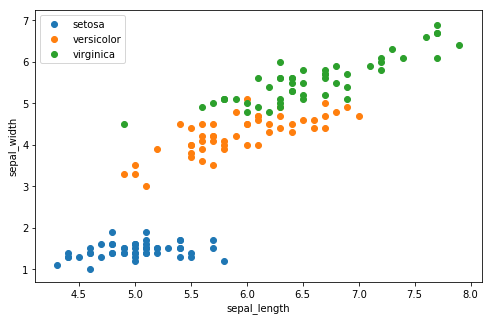

In [528]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
for sp, tdf in df.groupby('species'):
    # pass desired legend names to subgroups of data to label- or all groups will be labeled the same in legend
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = sp)
    handles.append(h)
    
ax.set(xlabel = 'sepal_length', ylabel = 'sepal_width')
ax.legend()

# 1.2 How do Legends Work?

When you call `ax.legend` after plotting your data, legend elements are automatically determined from the plotted "Artists", see this great [tutorial](https://dev.to/skotaro/artist-in-matplotlib---something-i-wanted-to-know-before-spending-tremendous-hours-on-googling-how-tos--31oo) for a more detailed explanation of this. 

For convenience, I'll reiterate some basic information about Artists
Basically, when you plot data using `Axes` methods such as `ax.plot` or `ax.scatter`, Artists are added to the `Axes` canvas.

When you call `ax.legend` the legend is created with these artists/labels (handles) 

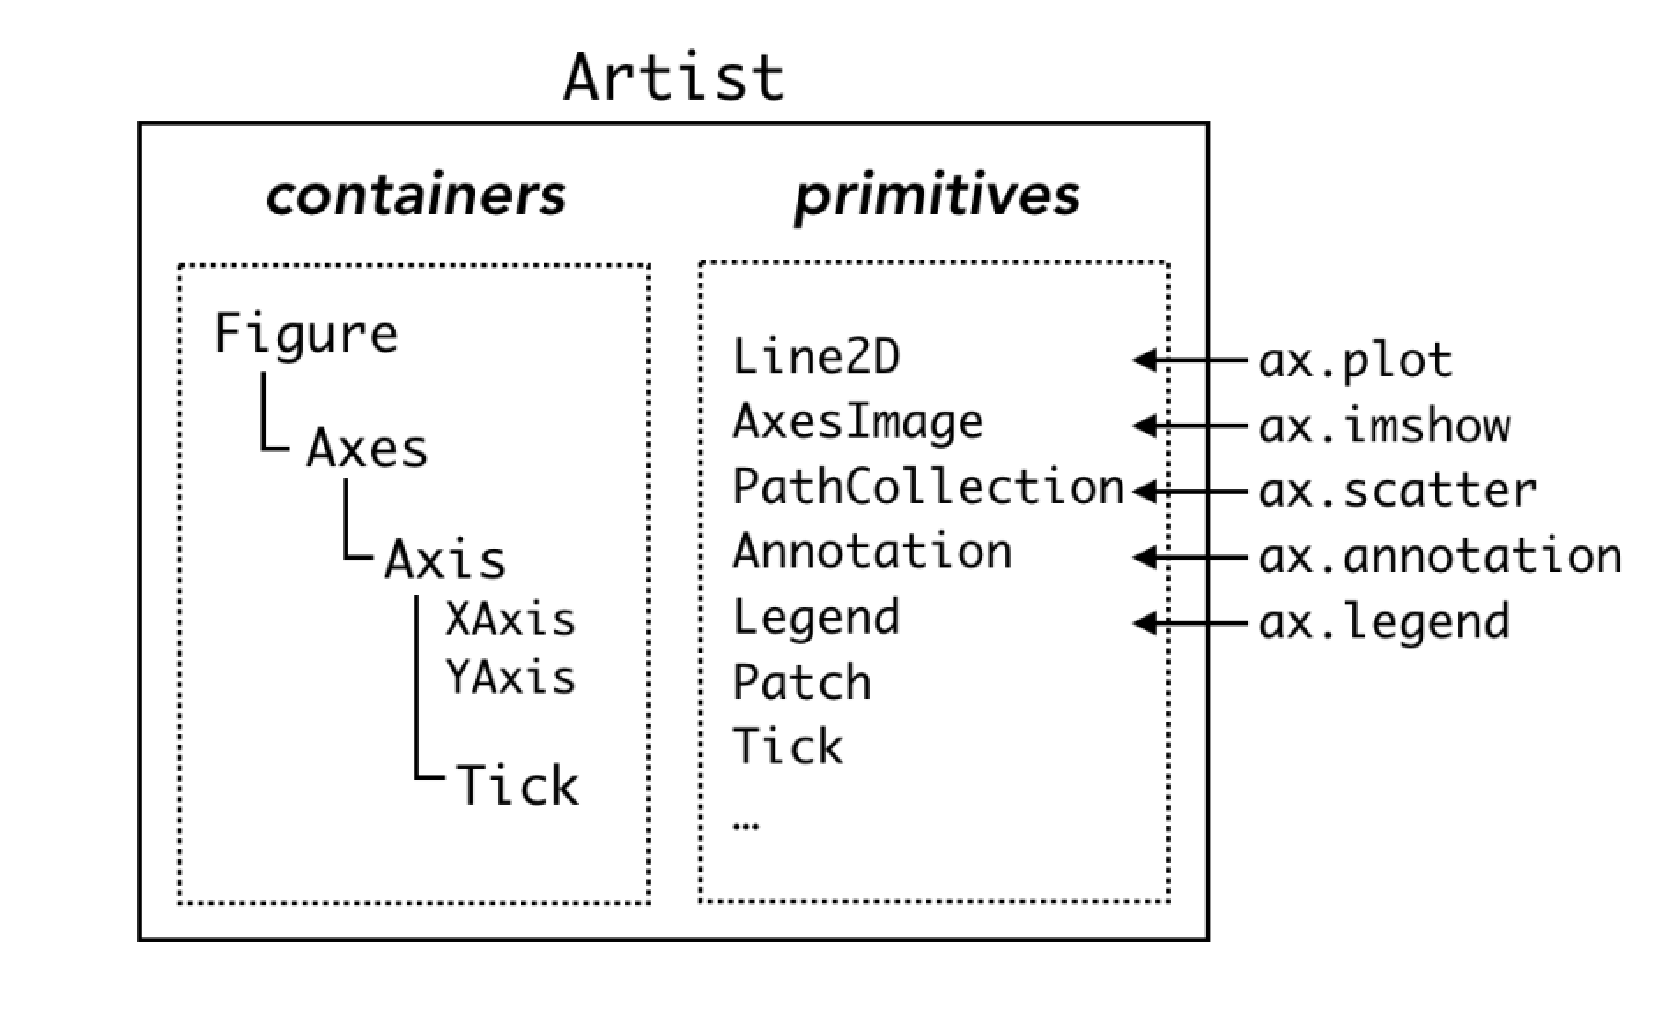

In [330]:
im = mpl.image.imread('media/Artists_scotaro.png')

fig, ax = plt.subplots(figsize = (10,10), dpi = 200)
ax.imshow(im)
ax.set_axis_off()



Note: Credit this diagram to ['@skotaro'](https://dev.to/skotaro) and the aforementioned tutorial


In [ ]:
/frazer01/home/djakubosky/repos/public/scientific-matplotlib/matplotlib_tutorials/media/Artists_scotaro.png

# 1.3 Excluding specific items from your legend, when you plot them
A common annoyance in using the automatic legend method, is that if you plot items that you don't wish to include on the legend, they will still appear, however, there are a few ways to remove them. Additionally, be aware that artists from some plotting methods will show up on the legend only if they have a label- this is true for `ax.axvline`

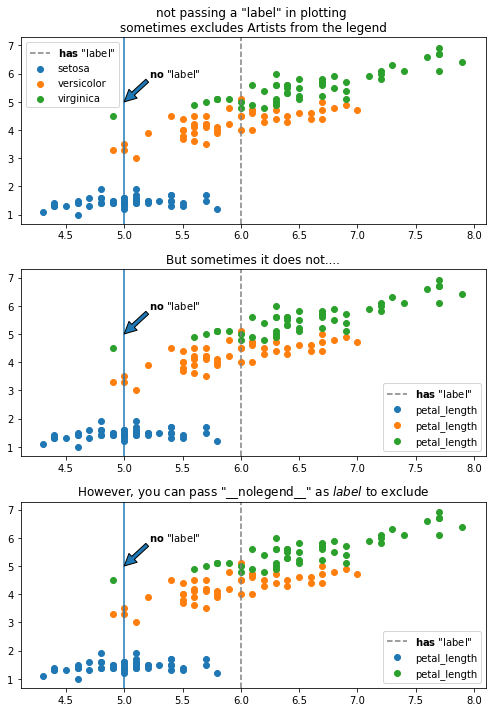

In [191]:
fig, axes = plt.subplots(3,1, figsize = (7,10))
ax = axes[0]
for sp, tdf in df.groupby('species'):
    # pass desired legend names to subgroups of data to label- or all groups will be labeled the same in legend
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = sp)
    
# some items such as axvline actually won't be added to the legend if you don't label them 
ax.axvline(5)
ax.annotate(xy = (5,5), s = '$\mathbf{no}$ "label"', 
            xytext = (25,25), textcoords = 'offset points', 
            arrowprops = {})

ax.axvline(6, label = '$\mathbf{has}$ "label"', color = 'grey', linestyle = '--')

ax.legend()
ax.set_title('not passing a "label" in plotting \n sometimes excludes Artists from the legend ')

ax = axes[1]
for sp, tdf in df.groupby('species'):
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'])
    
# some items such as axvline actually won't be added to the legend if you don't label them 
ax.axvline(5)
ax.annotate(xy = (5,5), s = '$\mathbf{no}$ "label"', 
            xytext = (25,25), textcoords = 'offset points', 
            arrowprops = {} )
ax.axvline(6, label = '$\mathbf{has}$ "label"', color = 'grey', linestyle = '--')

ax.legend(loc = 'lower right')
ax.set_title('But sometimes it does not....')


ax = axes[2]
for sp, tdf in df.groupby('species'):
    if sp == 'versicolor':
        h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = '__nolegend__')
    else:
        h = ax.scatter(tdf['sepal_length'], tdf['petal_length'])
    
    
    
# some items such as axvline actually won't be added to the legend if you don't label them 
ax.axvline(5)
ax.annotate(xy = (5,5), s = '$\mathbf{no}$ "label"', 
            xytext = (25,25), textcoords = 'offset points', 
            arrowprops = {} )
ax.axvline(6, label = '$\mathbf{has}$ "label"', color = 'grey', linestyle = '--')

ax.legend(loc = 'lower right')
ax.set_title('However, you can pass "__nolegend__" as $label$ to exclude')


plt.tight_layout()


# 2) Customizing Legends

## 2.1 Custom Defining Legend Using Artists
For greater control you can instead generate a list of handles (Artists with labels) and provide them directly to the `ax.legend` method. `Line2D` can take various markers, including latex symbols/texts, allowing you to use this artist to define many types of legend items. However, for more control, you'll need to define custom legend handler maps- some examples may also be found [here](https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend).  Below I've expanded upon an example given [here](https://matplotlib.org/3.1.0/gallery/text_labels_and_annotations/custom_legends.html) providing some added comments on things that aren't obvious from these tutorials.


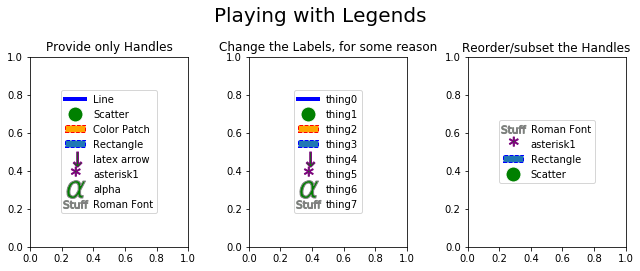

In [38]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


legend_elements = [# 1. standard line- if you don't define a marker
                   Line2D([0], [0], color='b', lw=4, label='Line'), 
                    #2. set lw = 0 for just a Circle
                   Line2D([0], [0], marker='o', color='w', label='Scatter', 
                          markerfacecolor='g', markersize=15),             
                   # 3. Patch is actually a Rectangle patch, with fc,ec, but no dims
                   mpatches.Patch(facecolor='orange', edgecolor='r',  
                         label='Color Patch', linestyle = '--'), 
                   # 4. See- Rectangle does the same thing as Patch
                   mpatches.Rectangle((0, 0), 0, 0,
                                      label = 'Rectangle', 
                                      linestyle = '--', linewidth = 1, 
                                      edgecolor = 'b'),
                   # 5/6 latex/mathtext symbols and text can also be used with Line2D
                   Line2D([0], [0], marker=r'$\downarrow$', color='purple', label='latex arrow',
                          markerfacecolor='g', markersize=15, lw = 0), 
                   Line2D([], [], marker=r'$ * $', color='purple', label='asterisk1',
                          markerfacecolor='g', markersize=15, lw = 0),
                   Line2D([], [], marker=r'$\alpha$', color='grey', label='alpha',
                          markerfacecolor='g', markersize=20, lw = 0),
                   Line2D([], [], marker=r"$\mathrm{Stuff}$", color='grey', label='Roman Font',
                          markerfacecolor='g', markersize=25, lw = 0)]  # or you can also use mathtext
                    
fig, axes = plt.subplots(1,3, figsize = (10,4))
axf = axes.flatten()
ax = axf[0]
ax.set_title('Provide only Handles')
# provide a list of handles- by default it will have the provided labels
ax.legend(handles=legend_elements, loc='center');


ax = axf[1]
ax.set_title('Change the Labels, for some reason')
# provide a list of handles- by default it will have the provided labels
labels = ['thing{}'.format(i) for i,l in enumerate(legend_elements)]
ax.legend(handles=legend_elements, labels = labels, loc='center');



ax = axf[2]
ax.set_title('Reorder/subset the Handles')
# you can always play around with this list of handles
# provide a list of handles- by default it will have the provided labels
leg = ax.legend(handles=legend_elements[::-1][::2], loc='center');


fig.suptitle('Playing with Legends', fontsize = 20)
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.9])

# Grabbing/Reusing Handles Cont.

Regardless of how they are drawn, you can get a list of handles on the plot, use them elsewhere/modify
and use them on other axes if you wish, or in both places, this can also allow you to exclude things from the legend.   
-The `ax.get_legend_handles_labels` method is helpful for this.  
-This is also useful if you are using Seaborn, you'll find that sometimes it creates legends with extra items to hide (eg `sns.scatterplot`).

However, you can only have one "legend" tied to an axes at a time, we will revisit this issue later.

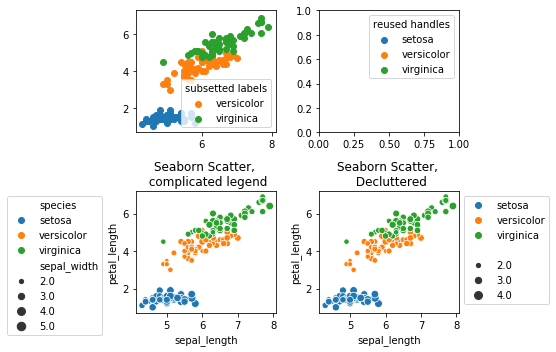

In [39]:
fig, axes = plt.subplots(2,2, figsize = (8,5))
axf = axes.flatten()
ax = axf[0]
for sp, tdf in df.groupby('species'):
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = sp)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles[1:], title = 'subsetted labels');


ax = axf[1]
ax.legend(handles = handles, title = 'reused handles');


ax = axf[2]

ax.set_title('Seaborn Scatter, \n complicated legend')
sns.scatterplot(x = 'sepal_length', y = 'petal_length', data = df, hue = 'species', ax = ax,
               size = 'sepal_width' )

# its long so I'll move it outside
leg = ax.legend(bbox_to_anchor = (-0.2, 1), loc = 'upper right')

handles, labels  = ax.get_legend_handles_labels()

# seaborn actually puts titles in legends as items of the legend in some cases
# things would look cleaner with white space 
t = set(['species','sepal_width'])
new_labels = [i if i not in t else '' for i in labels]


ax = axf[3]
sns.scatterplot(x = 'sepal_length', y = 'petal_length', data = df, hue = 'species', ax = ax,
               size = 'sepal_width' )
# lets clean it up and place it somewhere better
ax.legend(handles = handles[1:-1], labels = new_labels[1:-1], bbox_to_anchor = (1,1), loc = 'upper left')

ax.set_title('Seaborn Scatter, \n Decluttered')
plt.tight_layout()


# 2.3 Custom Legend Handlers
It is sometimes neccessary to create a custom legend handler class, if you wish to use a non-standard legend marker. 

Legend Handlers return an Artist.

When do you need to worry about this?  

   1) when you need to ensure texts are the same size      
   2) you want special shapes as the legend markers, that can't be passed via Line2D as scatter markers or as Rectangles
    

Others have described pretty well placing patches into the legend, for example this [stackoverflow](https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend)


There are several built in legend_handler classes that derive from `HandlerBase`, such as `HandlerCircleCollection`, to help build custom handlers,  a reference for them is [here](https://matplotlib.org/3.1.0/api/legend_handler_api.html)


Below I'll illustrate the issue as it pertains to special texts..


# Use-Case: Line2D with MathTexts/Latex Creates Texts that are Different Sizes
Lets say we want to display asterisks in a legend, with several asterisks indicating a lower p value, this doesn't look too good using "Proxy artists" - see matplotlib [legend tutorial](https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists)- But can be done like so - this solution is inspired by these two strong stackoverflow answers [1](https://stackoverflow.com/questions/43585333/seaborn-countplot-set-legend-for-x-values/43591678#43591678), [2](https://stackoverflow.com/questions/47372459/use-text-but-not-marker-in-matplotlib-legend), with a bit of detail added

In [33]:
from matplotlib.legend_handler import HandlerBase
import copy

#####LegendHandler just for Text can be made in this way
class TextHandler(HandlerBase):
    # a create_artists method always part of a legend_handler returns a list of artists
    def create_artists(self, legend, orig_handle,xdescent, ydescent,
                            width, height, fontsize,trans):
            h = copy.copy(orig_handle)
            # center the Text within the region between label and Legend Bbox
            h.set_position((width/2.,height/2.))
            h.set_transform(trans)
            h.set_ha("center");
            h.set_va("center");
            return [h]

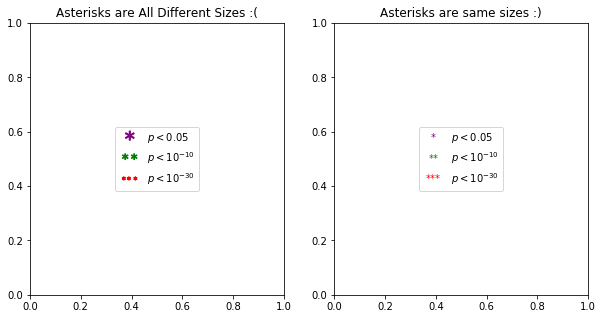

In [40]:
labels = ['$p < 0.05$', '$p < 10^{-10}$', '$p < 10^{-30}$']
markers = [r'$   *$', r'$  **$', r'$ ***$']
colors = ['purple', 'green', 'red']
legend_elements = []

for i in range(len(markers)):
    l = Line2D([], [], marker= markers[i], color=colors[i], label=labels[i],
                          markerfacecolor='g', markersize=15, lw = 0)
    legend_elements.append(l)

fig, axes = plt.subplots(1,2, figsize = (10,5))
ax = axes[0]
ax.set_title('Asterisks are All Different Sizes :(')
# provide a list of handles- by default it will have the provided labels
ax.legend(handles=legend_elements, loc='center');


########### Use the Custom Handler Instead ######
texts = []
leg_texts = ['*', '**', '***']
labels = ['$p < 0.05$', '$p < 10^{-10}$', '$p < 10^{-30}$']
fs = 10
for i, lt in enumerate(leg_texts):
    t = plt.Text(x=0, y = 0, text = lt, color = colors[i],
             size = 10, label = labels[i])
    texts.append(t)
    
# a handler map dict needs to then be created mapping artist type to the custom legend handler class
handlermap = {type(texts[0]) : TextHandler()} 
ax  = axes[1]

ax.set_title('Asterisks are same sizes :)')
ax.legend(handles=texts, loc='center', handler_map=handlermap);


# 2.4 A Custom Handler That can Handle Lots of Different Patches
It is also possible to utilize the vertices information from other types of Artists to build a custom handler that can work for multiple unique situations. A similar strategy can be used with basemaps in matplotlib- see [here](https://stackoverflow.com/questions/42639981/how-to-show-shapefile-label-in-python-basemap-legend?noredirect=1&lq=1) 

In [11]:
# class will handle most patches 
class PathPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        aspect= height/float(width)
        center = 0.5 * width - 0.5 * x0, 0.5 * height - 0.5 * y0
#         print x0, y0, width, height
        pth = orig_handle.get_path()
        verts = pth.vertices
        codes = pth.codes
        
        minx, miny = verts[:,0].min(), verts[:,1].min()
        maxx, maxy = verts[:,0].max(), verts[:,1].max()
        aspect= (maxy-miny)/float((maxx-minx))
        
        nvx = (verts[:,0]-minx)*float(height)/aspect/(maxx-minx)-x0
        # center artist within the handlebox
        
#         nvx =  (np.c_[nvx] + center[0]).T.tolist()[0]
        nvy = (verts[:,1]-miny)*float(height)/(maxy-miny)-y0
        verts_mod = np.c_[nvx, nvy]
        pth2 = mpath.Path(verts_mod, codes)
        p = mpatches.PathPatch(pth2, zorder = 20)
        p.set_facecolor(orig_handle.get_fc())
        p.set_edgecolor(orig_handle.get_ec())
#         p.update_from(orig_handle)
        p.set_transform(handlebox.get_transform())
        handlebox.add_artist(p)
        return p

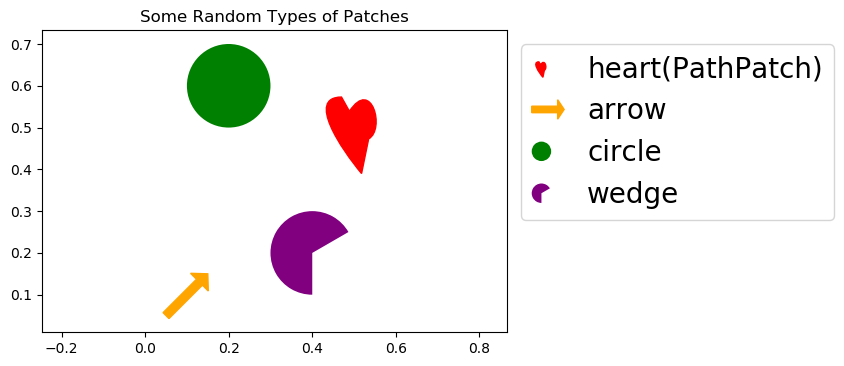

In [37]:
fig, ax = plt.subplots(dpi = 100)
Path = mpath.Path
path_data = [
    (Path.MOVETO, [0.018, -0.11]),
    (Path.CURVE4, [-0.031, -0.051]),
    (Path.CURVE4, [-0.115, 0.073]),
    (Path.CURVE4, [-0.03, 0.073]),
    (Path.LINETO, [-0.011, 0.039]),
    (Path.CURVE4, [0.043, 0.121]),
    (Path.CURVE4, [0.075, -0.005]),
    (Path.CURVE4, [0.035, -0.027]),
    (Path.CLOSEPOLY, [0.018, -0.11])]
codes, verts = zip(*path_data)
path = mpath.Path(verts + np.array([0.5, 0.5]), codes)
## add a heart custom path object
heart = mpatches.PathPatch(path, label = 'heart(PathPatch)', 
                           color = 'red', zorder = 20)

# add an arrow 
arrow = mpatches.Arrow( 0.05, 0.05, 0.1, 0.1,
                       width=0.1, color = 'orange', label = 'arrow')
# add a circle
circle = mpatches.Circle([0.2, 0.6], 0.1, ec="none", 
                         label = 'circle', color = 'green')
# add a wedge 
wedge = mpatches.Wedge([0.4, 0.2], 0.1, 30, 270, ec="none", 
                       color = 'purple', label = 'wedge')

# add artists to the plot
patches = [heart, arrow, circle, wedge]
for ptch in patches:
    ax.add_patch(ptch)
# map all of those artist types to the handler we built
handlermap = {type(i):PathPatchHandler() for i in patches}
leg = ax.legend(handles=patches, handler_map = handlermap, fontsize = 20, 
          bbox_to_anchor = (1,1), loc = 'upper left', handletextpad = 0)
ax.axis('equal')
ax.set_title('Some Random Types of Patches');


# 3. Combining Multiple Legends

Sometimes you may want a legend subdivided in complicated ways, with whitespaces, or subheadings for different things. This is difficult when you make one single legend, why?

1. It is hard to get things into the right columns
2. you can only have one title per legend- subheadings could instead be placed as artists/legend elements- this is annoying
3. As seen above, sometimes legends are easy to make, sometimes they require special considerations- you might want to combine legends from several plots into one mega legend


To take advantage of the aspects of individual legends, we can instead manipulate their **bounding boxes** to create a super legend

### Adding Multiple Legends to The Same Plot
As mentioned earlier, you can only have one legend attached to an "axes" officially at one time

To add multiple you need to `ax.add_artist` to add it explicitly, and then build the next legend.  

In [5]:
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches

In [27]:
tips = sns.load_dataset('tips')
iris = sns.load_dataset('iris')

In [3]:
def plot_shapes(ax):
    Path = mpath.Path
    path_data = [
        (Path.MOVETO, [0.018, -0.11]),
        (Path.CURVE4, [-0.031, -0.051]),
        (Path.CURVE4, [-0.115, 0.073]),
        (Path.CURVE4, [-0.03, 0.073]),
        (Path.LINETO, [-0.011, 0.039]),
        (Path.CURVE4, [0.043, 0.121]),
        (Path.CURVE4, [0.075, -0.005]),
        (Path.CURVE4, [0.035, -0.027]),
        (Path.CLOSEPOLY, [0.018, -0.11])]
    codes, verts = zip(*path_data)
    path = mpath.Path(verts + np.array([0.5, 0.5]), codes)
    ## add a heart custom path object
    heart = mpatches.PathPatch(path, label = 'heart(PathPatch)', zorder = 20, color = 'red')

    # add an arrow 
    arrow = mpatches.Arrow( 0.3, 0.5, 0.1, 0.1,
                           width=0.1, color = 'orange', label = 'arrow')
    # add a circle
    circle = mpatches.Circle([0.6, 0.8], 0.1, ec="none", 
                             label = 'circle', color = 'green', )
    # add a wedge 
    wedge = mpatches.Wedge([0.4, 0.2], 0.1, 30, 270, ec="none", 
                           color = 'purple', label = 'wedge')
    patches = [heart, arrow, circle, wedge]
    for ptch in patches:
        ax.add_patch(ptch)
    return ax, patches
    

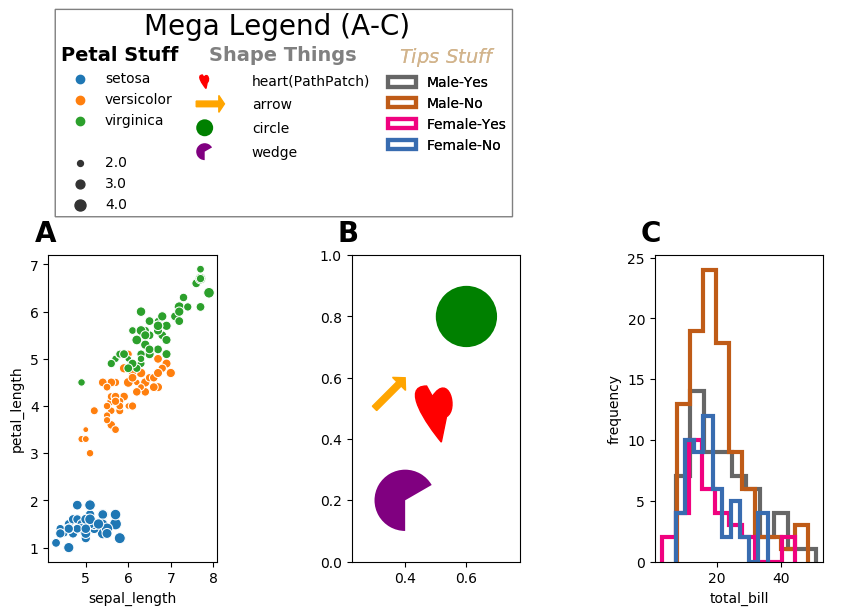

In [42]:
fig =plt.figure(figsize=(10,7), dpi = 100)
gs = mpl.gridspec.GridSpec(2, 3, 
                           figure =fig, height_ratios = [0.5, 1], wspace = 0.8,
                           hspace=0.3)

ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1], aspect = 'equal', adjustable = 'datalim')
ax3 = fig.add_subplot(gs[1,2])

leg_ax = fig.add_subplot(gs[0, :])  #### We will place a mega legend in its own axes for flexibility



ax = ax1
sns.scatterplot(x = 'sepal_length', y = 'petal_length', data = iris, hue = 'species', ax = ax,
               size = 'sepal_width' )
# lets clean it up and place it somewhere better
handles_ax1, labels_ax1  = ax.get_legend_handles_labels()
ax.legend().remove()
t = set(['species','sepal_width'])
new_labels_ax1 = [i if i not in t else '' for i in labels_ax1]  #### Handles/new labels for ax1 

ax = ax2
ax, patches_shapes = plot_shapes(ax)
handlermap_shapes = {type(i):PathPatchHandler() for i in patches_shapes} #### Handles for ax2 (shapes)

ax = ax3 

cm = mpl.cm.Accent_r
count = 0
for g, tdf in tips.groupby(('sex', 'smoker')):
    ax.hist(tdf['total_bill'],histtype= 'step', lw = 3, color = cm(count), 
            label = '{}-{}'.format(*g))
    count +=1
ax.set(xlabel = 'total_bill', ylabel='frequency')  
handles_ax3, labels_ax3 = ax.get_legend_handles_labels()  #### Handles for ax3


####### Now lets make a Mega Legend #########################

loc_y = 1
bbox_offset = 0 # fudge with to space them as desired

inv = leg_ax.transData.inverted() # a transform needed to determine where to place other legends

leg = leg_ax.legend(handles = handles_ax1[1:-1], labels = new_labels_ax1[1:-1],
                    bbox_to_anchor = (0,loc_y), loc = 'upper left',
                   frameon= True, ncol=1,
                    fontsize=10, title = 'Petal Stuff')
t = leg.get_title().set_fontweight('bold')
t = leg.get_title().set_fontsize(14)

leg_ax.add_artist(leg)
############### Offset Legend 2 from Legend 1
############### Determine where the next bbox should be drawn
fig.canvas.draw()  #### Canvas must be drawn to update the actual position of legend bbox
f = leg.get_frame()
b = f.get_bbox()
c1 = inv.transform(b) ### Determine where to place the bbox_to_anchor in leg_ax coords


leg2 = leg_ax.legend(handles = patches_shapes, handler_map = handlermap_shapes,
                    bbox_to_anchor = [c1[1][0]-bbox_offset, loc_y],
                    loc = 'upper left', frameon= True, ncol=1,
                    fontsize=10, title = 'Shape Things', handleheight = 1.5, handletextpad = 2)
t = leg2.get_title().set_fontsize(14)
t = leg2.get_title().set_fontweight('bold')
t = leg2.get_title().set_color('grey')
leg_ax.add_artist(leg2)

########## Offset Legend 3 from Legend 2
fig.canvas.draw()
f = leg2.get_frame()
b = f.get_bbox()
c2 = inv.transform(b) ## Determine where to place the bbox_to_anchor in leg_ax coords



leg3 = leg_ax.legend(handles = handles_ax3, bbox_to_anchor = [c2[1][0] - bbox_offset, loc_y],
                          loc = 'upper left', frameon= True, ncol=1,
                          fontsize= 10, title = r'$Tips\ Stuff$')

t = leg3.get_title().set_fontweight('bold')
t = leg3.get_title().set_fontsize(14)
t = leg3.get_title().set_color('tan')
leg_ax.add_artist(leg3)


fig.canvas.draw()
f = leg3.get_frame()
b = f.get_bbox()
c = inv.transform(b)
c3 = c

for l in [leg, leg2, leg3]: ### Turn off all the individual frames, everything is aligned
        l.set_frame_on(False)

#################### Draw One Large BBox around the whole thing- leaving Space for A SupTitle

buff_top = 0.2
bb = mtransforms.Bbox([[c1[0][0], c1[0][1]], [c3[1][0], c3[1][1] + buff_top]])
p_fancy = mpatches.FancyBboxPatch((bb.xmin, bb.ymin),
                             abs(bb.width), abs(bb.height),
                             boxstyle="round,pad=0",
                             fc='w',
                             ec='grey', clip_on= False)

#### Add the SupTitle 
leg_ax.add_patch(p_fancy)
b = p_fancy.get_bbox()
center = (b.xmax - b.xmin)/2
height = c1[1][1]
leg_ax.text(center, height, r'Mega Legend (A-C)', fontsize = 20, ha = 'center', va = 'bottom')
leg_ax.set_axis_off()

##### Lets Label them Now Offset the Top Corner
lettering = 'ABC'
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.annotate(xy = (0,1), s = lettering[i], xytext = (-10, 10), textcoords = 'offset points',
                xycoords = 'axes fraction', weight = 'bold', fontsize = 20)